# background

## our model


Simulated agents sequentially sample evidence from two sources $s = \{memory, vision\}$. We assume samples from both sources are generated according to a Bernoulli distribution with unknown generating parameter $\theta_s$, and that observers' encoding of these samples is slightly corrupted by Gaussian noise:

\begin{align}
o_{s_t} \sim Bernoulli(\theta_s) + Normal(0, 1) \tag{1}
\end{align}


Next, we posit that observers use these observed samples to form and update a belief $g_s(t)$ about the value of $\theta_s$ for each evidence source, which we model as a continuously-updating Beta distribution:

$$\begin{align}
    g_s(t) \equiv p(\theta_s | o_{s_t}, o_{s_{t-1}}, \ldots, o_{s_{t_0}}) \sim \text{Beta}(\alpha_s, \beta_s) \tag{2}
\end{align}$$

\begin{align}
    g_s(t) \equiv \begin{cases}
        Beta(\alpha_{s_{t-1}}+1, \beta_{s_{t-1}}), & \text{ if } \hspace{0.15cm} o_{s_{t}} > 0 \\
        Beta(\alpha_{s_{t-1}}, \beta_{s_{t-1}}+1),& \text{ if } \hspace{0.15cm} o_{s_{t}} < 0 \tag{3}
        \end{cases}
\end{align}

The Beta distribution captures observers' belief about the possible values of $\theta_s$ for each evidence source. We define the precision estimate driving dynamic integration as the inverse entropy of this belief:

\begin{align}
    \lambda_{s}(t) = H(g_s(t))^{-1} \tag{4}
\end{align}

We define the optimal weighting of each evidence source using the standard ideal-observer model of cue integration:

\begin{align}
    w_{memory_{t}} = \frac{\lambda_{memory} (t)}{\lambda_{vision}(t) +
    \lambda_{memory}(t)};  \hspace{0.25cm}
    w_{vision}(t) = \frac{\lambda_{vision}(t)}{\lambda_{vision}(t) + \lambda_{memory}(t)} \tag{5}
\end{align}

Observers weight each observation from each evidence source by these source-specific weights, creating a decision variable that is a time-varying precision-weighted sum of samples from independent streams of memory and visual evidence:
\begin{align}
    DV_t = DV_{t-1} + o_{memory_{t}}w_{memory_{t}} + o_{vision_{t}}w_{vision_{t}} \tag{6}
\end{align}

The decision process terminates according to:
\begin{align}
    |DV_t | > a \tag{7}
\end{align}
where $a$ is a scalar defining the boundary separation (threshold) value.

Finally, the model assumes that memory samples are generated at a fraction of the rate that visual samples are received by the observer, such that the total number of samples generated by each evidence source (memory and vision) is given by:
\begin{align}
    n_{memory} = n_{vision} \cdot \gamma^{-1} \tag{8}
\end{align}

Accordingly, time-varying estimates for memory evidence are updated with a frequency defined by $\gamma$.



---



### example trials

gray areas = epochs when visual evidence consists solely of noise

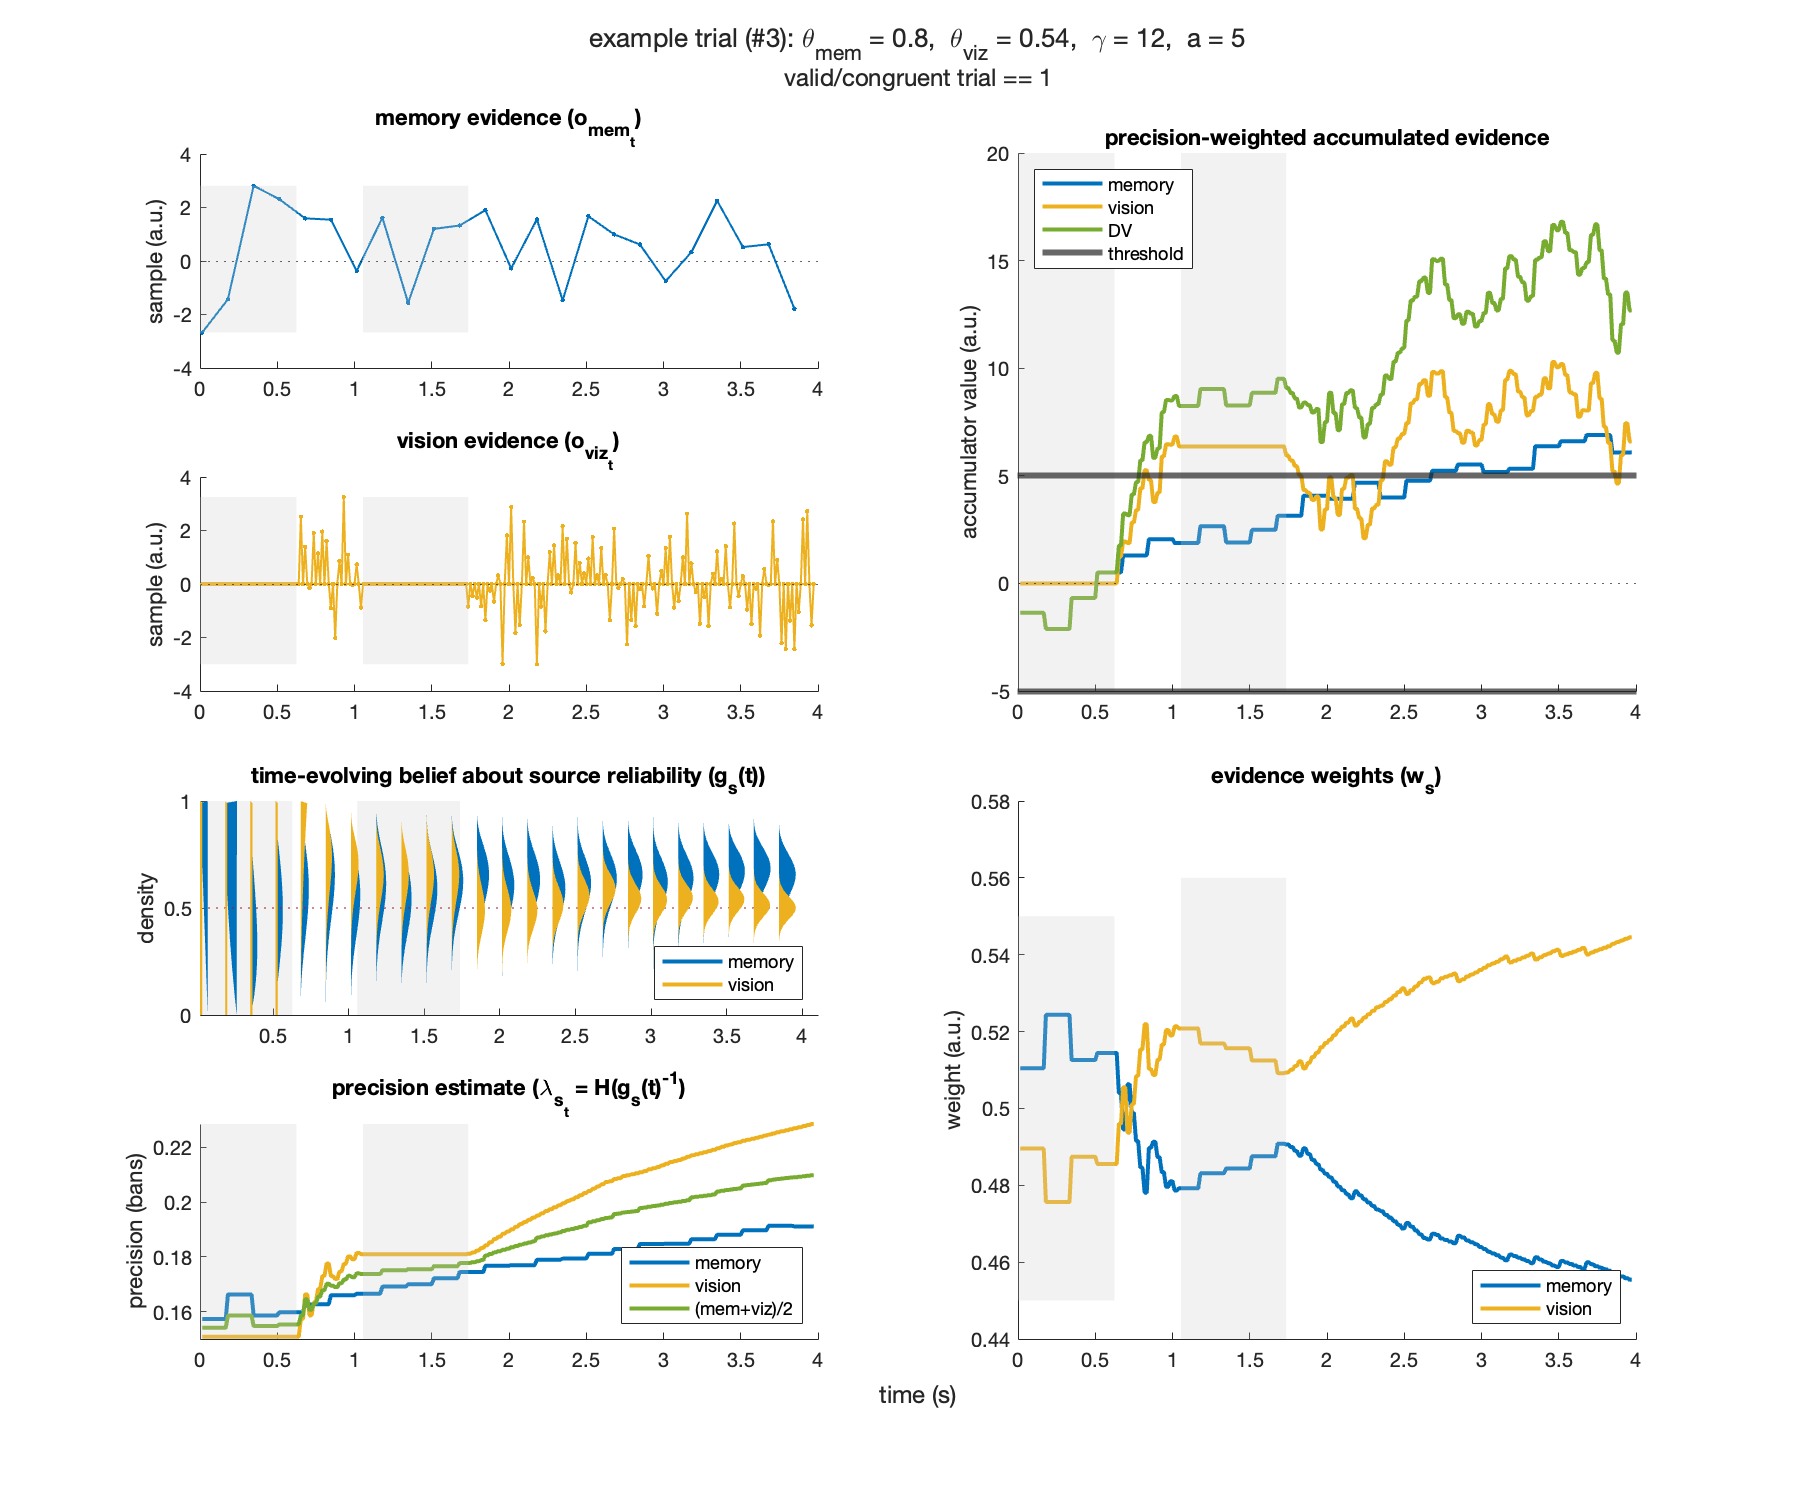

Importantly, each cue's validity is _probabilistic_: it correctly predicts the outcome of the perceptual decision for a proportion of trials defined by $Θ_{mem}$ .

In the example above, $Θ_{mem} = 0.8$, meaning that 20% of the decision trials will be made with an _invalid_ or _incongruent_ expectation. An example of this type of trial is displayed below:

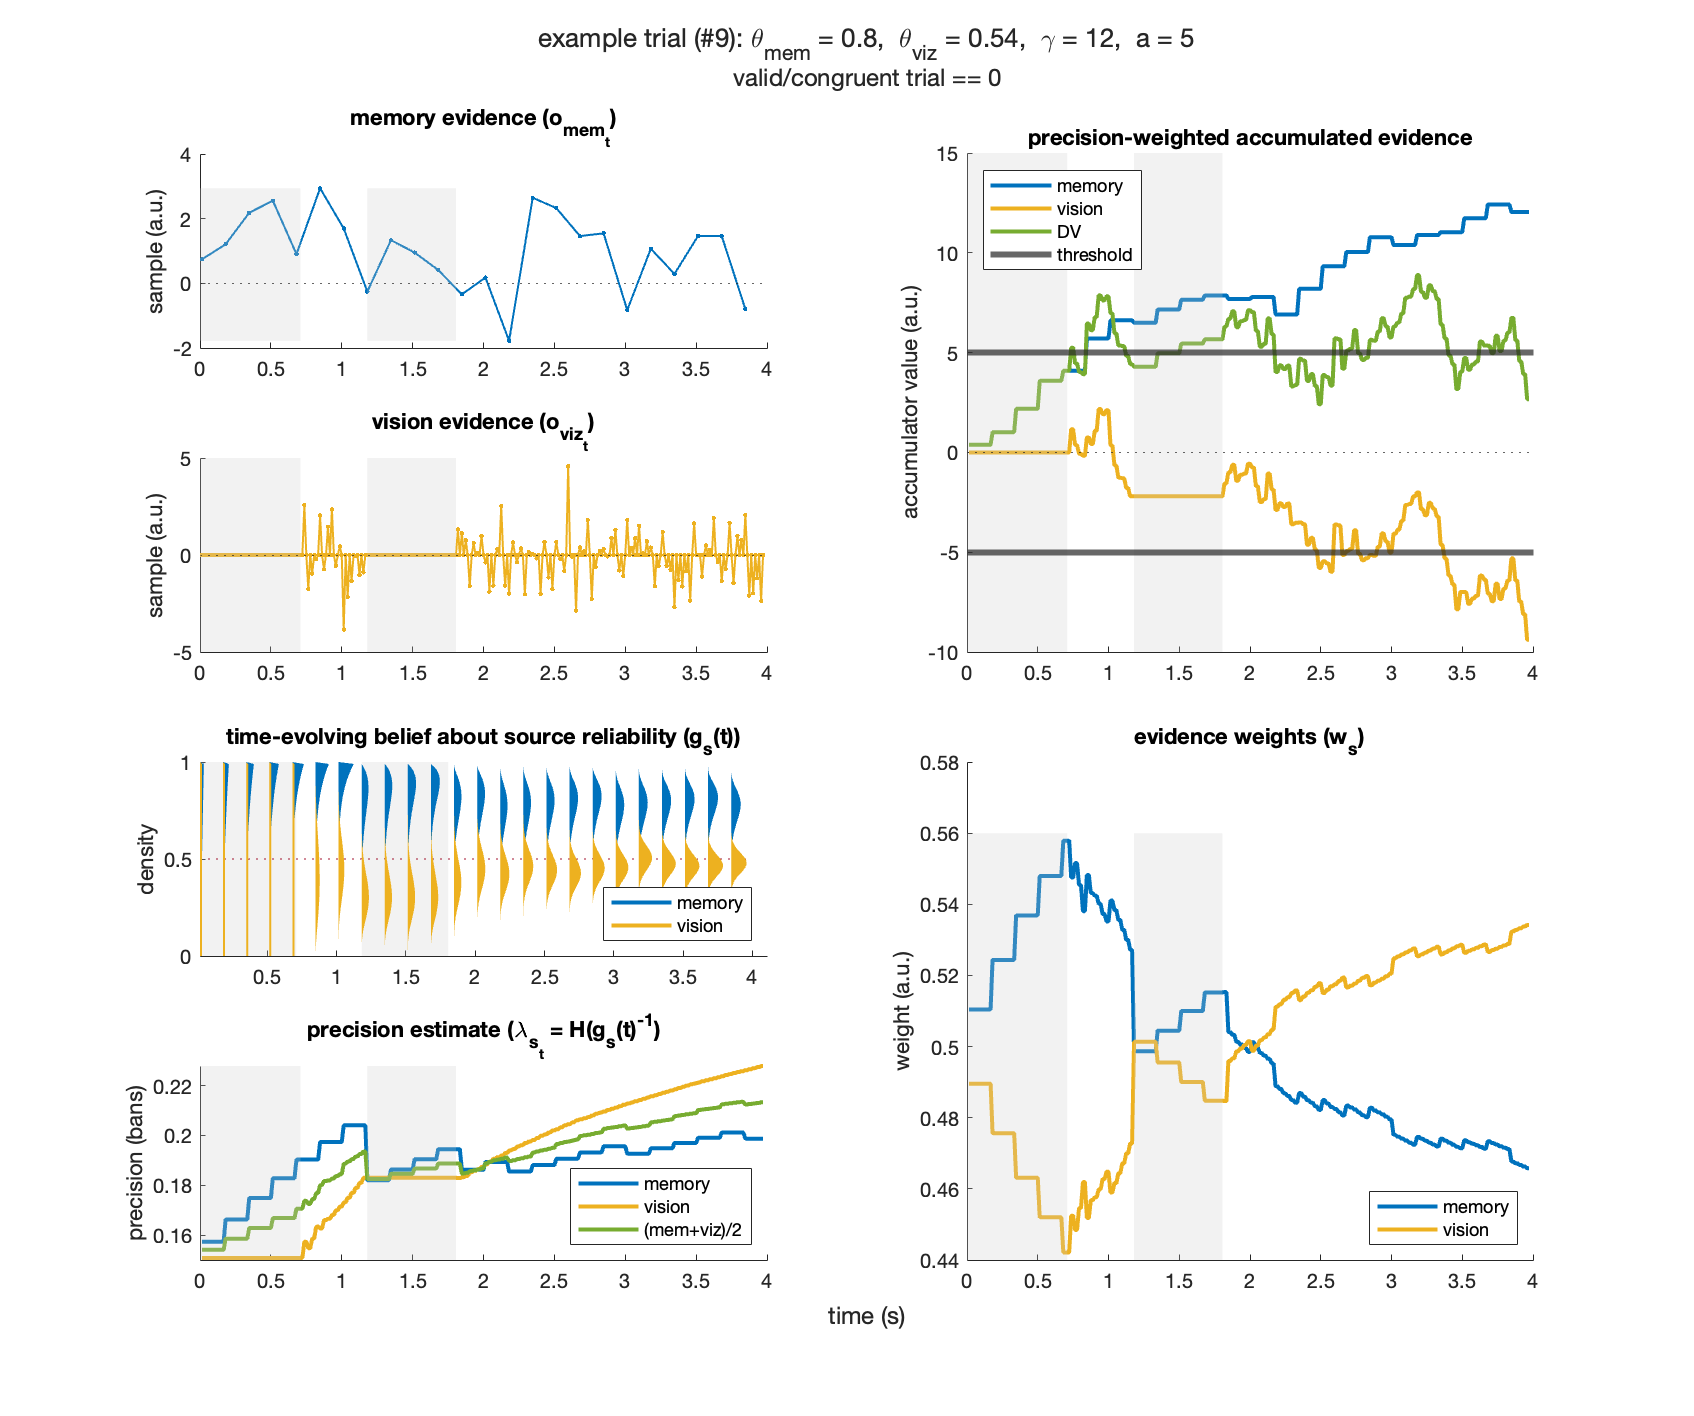

## specification ideas

1. can account for signal/noise epochs using the solution from the changing signal strength cookbook

## our experiment

to be filled out


## related models

- Turner & Gao et al (2017): [the averaging diffusion model](https://link.springer.com/article/10.3758/s13423-017-1255-2)
  - the "adaptive optimal weight" model seems nearly identical to our model, except it doesn't draw a distinction between objective and subjective evidence reliability
- Drugowitsch et al (2014): [optimal multi-sensory decision making in a reaction time task](https://elifesciences.org/articles/03005)
  - need to revisit / read more closely


A challenge in applying both of these models to our data is that they both were developed for tasks where observers really were presented with two simultaneous streams of sensory evidence. Our experimental design ensures that observers do have simultaneous/continuous access to the memory cue, but we do not know the timecourse of their putative memory sampling processes.

---

## methodological help
- Lombardi & Hare (preprint): [Piecewise constant averaging methods allow for fast and accurate hierarchical Bayesian estimation of drift diffusion models with time-varying evidence accumulation rates](https://osf.io/5azyx_v1)




# interactive simulation of first-pass model specification

In [ ]:
def coherence_changes(t, coherence, cue, thinning, noise1_duration, signal1_duration, noise2_duration):
    if t < noise1_duration:
      return cue/thinning
    elif t > noise1_duration and t < noise1_duration + signal1_duration:
      return coherence + (cue/thinning)
    elif t > noise1_duration + signal1_duration and t < noise1_duration + signal1_duration + noise2_duration:
      return cue/thinning
    else:
      return coherence + (cue/thinning)

def boundary(threshold):
  return threshold

m = pyddm.gddm(drift=coherence_changes,
               mixture_coef=0.2,
               T_dur=3.5,
               bound=lambda t,initial_bound,collapse_rate : initial_bound * np.exp(collapse_rate*t),
               nondecision=0,
               parameters={"noise1_duration": (0, 1.25), "signal1_duration": (0.42, 1), "noise2_duration": (0.63, 1.25),
                           "coherence": (0.5,1), "cue": (0,1), "thinning": (1,36), "threshold": (0.5,3), "initial_bound": (0.5,5), "collapse_rate":(-5,5)})

pyddm.plot.model_gui_jupyter(m)

Output()

# parameter recovery attempt

In [ ]:
# specify generating model
true_model = pyddm.gddm(drift=coherence_changes,
                        mixture_coef=0,
                        T_dur=4,
                        bound=1.5,
                        nondecision=0,
                        parameters={"noise1_duration": 0.75, "signal1_duration": 0.75, "noise2_duration": 1,
                           "coherence": 0.7, "thinning": 4},
                        conditions=["cue"])

# simulate 1600 trials with 80% cue
strongCue_sample = true_model.solve(conditions={"cue": 0.8}).sample(1600)

# simulate 1000 trials with 50% cue
neutralCue_sample = true_model.solve(conditions={"cue": 0.5}).sample(1000)

# simulate 400 trials with 20% cue
weakCue_sample = true_model.solve(conditions={"cue": 0.2}).sample(400)

# concatenate into one sample
sim_data = strongCue_sample + neutralCue_sample + weakCue_sample

# visualize model fit over simulated data
pyddm.plot.model_gui_jupyter(true_model, sim_data)

# fit model
fitting_model = pyddm.gddm(drift='cue', mixture_coef=0, T_dur=4, bound=1.5, nondecision=0, starting_position=0, dx=0.001, dt=0.001, parameters={'cue': (0.1, 0.9)})

# apply the fitting model to simulated data
fitting_model.fit(sim_data, lossfunction=pyddm.LossBIC, verbose=False)

# get printout of results
fitting_model.show()

# get fixed & fitted parameter values
print(fitting_model.parameters())

# visualize fitting success
pyddm.plot.plot_fit_diagnostics(model=fitting_model, sample=sim_data)

# get BIC value
fitting_model.get_fit_result().value()

Output()

Info: Params [0.52396871] gave 10062.218879802396
Info:pyddm:Params [0.52396871] gave 10062.218879802396


Model cue information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 0.523969
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.500000
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fixed parameters:
    - x0: 0.000000
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fixed parameters:
        - nondectime: 0.000000
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.000000
Fit information:
    Loss function: BIC
    Loss function value: 10062.218879802396
    Fitting method: differential_evolution
    Solver: auto
    Other propert